In [1]:
import pathlib
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 

import tensorflow as tf 

from tensorflow import keras 
from tensorflow.keras import layers

print(tf.__version__)

2.3.1


In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

&#39;/Users/mei/.keras/datasets/auto-mpg.data&#39;

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

In [9]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin==2)*1.0
dataset['Japan'] = (origin==3)*1.0
dataset.tail()

KeyError: &#39;Origin&#39;

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

&lt;seaborn.axisgrid.PairGrid at 0x149b21910&gt;

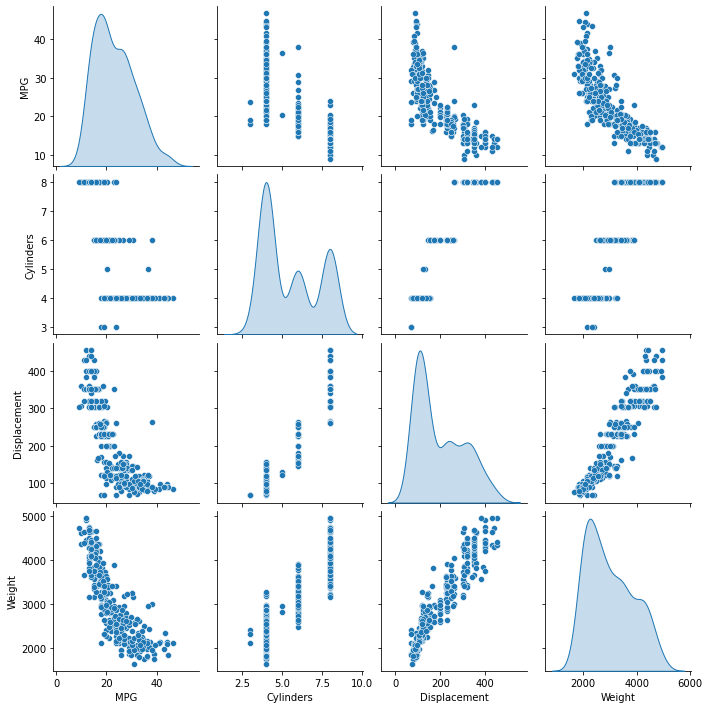

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


In [12]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.531847,1.729449,3.0,4.000,4.0,8.00,8.0
Displacement,314.0,197.855096,106.501896,68.0,105.000,151.0,302.00,455.0
Horsepower,314.0,105.971338,39.636557,46.0,76.000,95.0,130.00,230.0
Weight,314.0,3005.745223,859.060925,1649.0,2231.000,2831.5,3641.75,4955.0
Acceleration,314.0,15.510828,2.803560,8.0,13.625,15.5,17.00,24.8
Model Year,314.0,75.910828,3.688989,70.0,73.000,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.000,1.0,1.00,1.0
Europe,314.0,0.171975,0.377961,0.0,0.000,0.0,0.00,1.0
Japan,314.0,0.203822,0.403481,0.0,0.000,0.0,0.00,1.0


In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

KeyError: &#39;MPG&#39;

In [15]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [20]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu',input_shape=[len(train_dataset.keys())]),
        layers.Dense(64,activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae','mse']
        )
    return model
model = build_model()

In [21]:
model.summary()

Model: &quot;sequential_2&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [22]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.22739598],
       [ 0.0408411 ],
       [-0.12995476],
       [ 0.04186495],
       [ 0.03345966],
       [-0.05261841],
       [-0.35493246],
       [ 0.0764049 ],
       [ 0.16243193],
       [-0.30980423]], dtype=float32)

In [23]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch%100==0:print('')
        print('.',end='')
EPOCHS = 1000
history = model.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.304021,0.967717,2.304021,4.336730,1.691598,4.336730,995
996,2.384961,0.996888,2.384961,4.495329,1.673947,4.495329,996
997,2.509634,1.018020,2.509634,4.424859,1.662904,4.424859,997
998,2.252925,0.973733,2.252925,4.619477,1.708727,4.619477,998
999,2.413028,0.986312,2.413028,4.294071,1.642317,4.294071,999


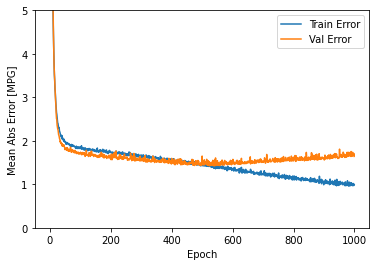

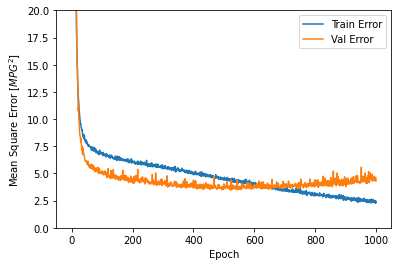

In [27]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


.......................................................................................

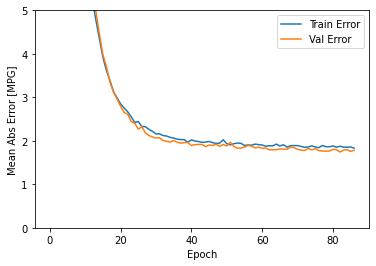

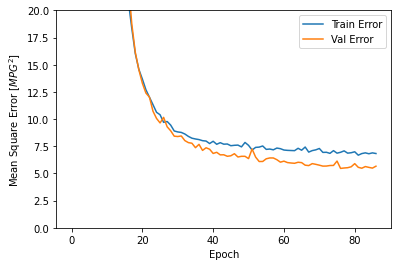

In [28]:
model = build_model()

# patience は改善が見られるかを監視するエポック数を表すパラメーター
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

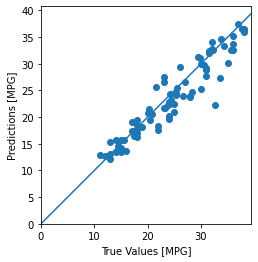

In [29]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])